In [1]:
!git clone https://github.com/albertakn/text_2_image.git
!pip install -r text_2_image/requirements.txt

Cloning into 'text_2_image'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 117 (delta 34), reused 68 (delta 7), pack-reused 0
Receiving objects: 100% (117/117), 4.19 MiB | 9.00 MiB/s, done.
Resolving deltas: 100% (34/34), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
from google.colab import drive

#Чтобы модель заработала, необходимо скачать веса отсюда:
#https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt
#Я сделал это заранее, поэтому просто подгружаю их из своего google drive
drive.mount('/content/drive')
!cp drive/MyDrive/diploma/v1-5-pruned-emaonly.ckpt text_2_image/data/v1-5-pruned-emaonly.ckpt

Mounted at /content/drive


# Download concept

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

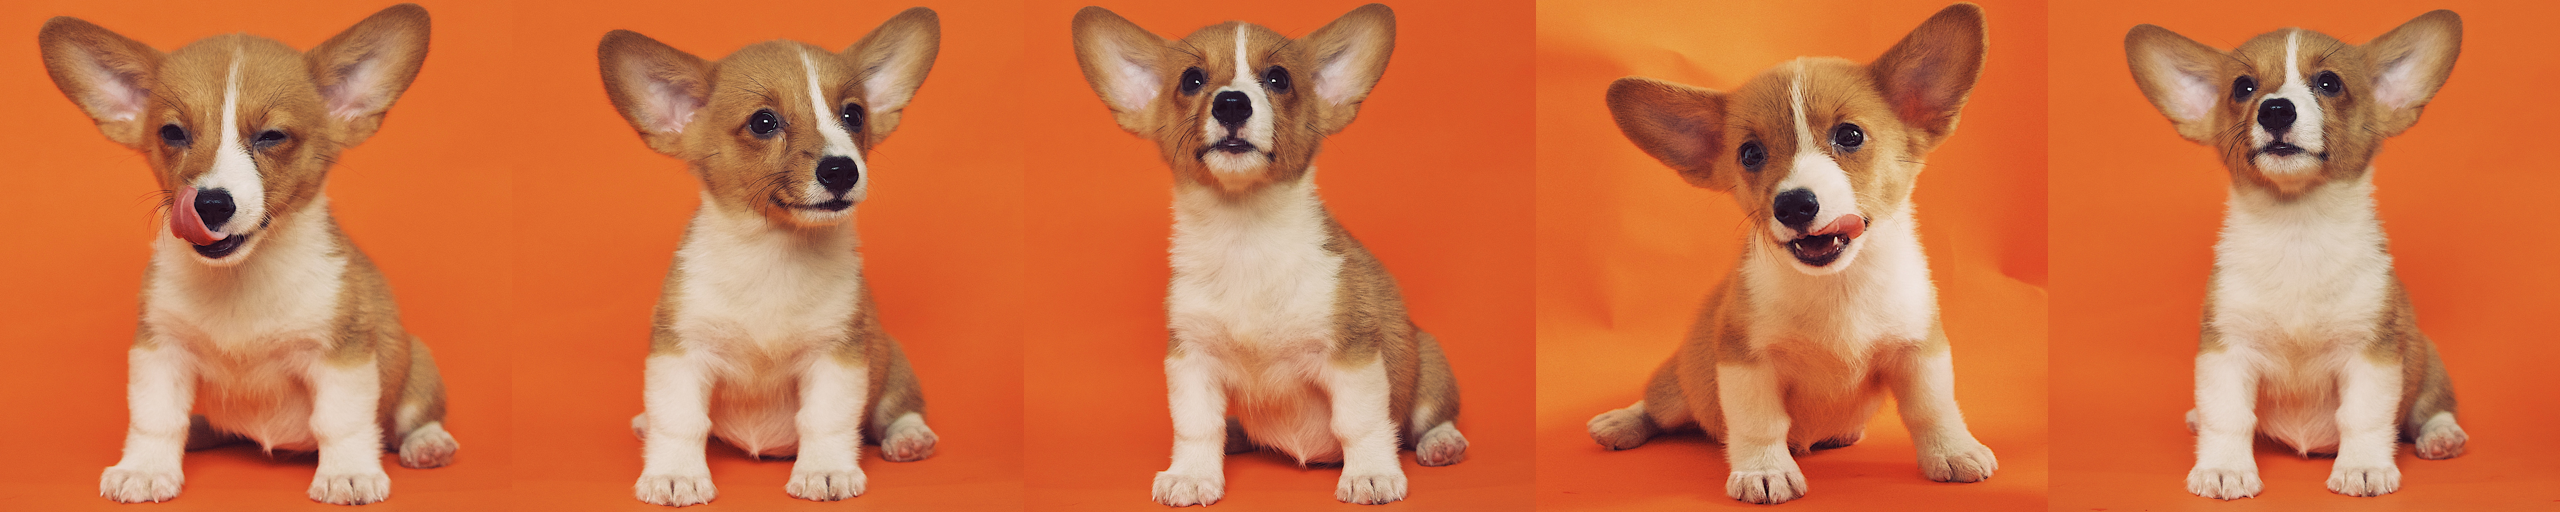

In [3]:
import requests
import glob
from io import BytesIO
import os
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)

images = []
for file_path in os.listdir(local_dir):
  try:
      image_path = os.path.join(local_dir, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

# Prepare model

In [9]:
from transformers import CLIPTokenizer
from PIL import Image
from text_2_image.stable_diffusion.util.model_loader import load_models_from_standard_weights
from text_2_image.stable_diffusion.pipeline.pipeline import generate
from text_2_image.dreambooth.dreambooth import run_dreambooth

device = 'cuda'
tokenizer = CLIPTokenizer("text_2_image/data/vocab.json", merges_file="text_2_image/data/merges.txt")
models = load_models_from_standard_weights('text_2_image/data/v1-5-pruned-emaonly.ckpt', 'cuda')


# Initialize hyperparameters for dreambooth


In [10]:
hyperparameters = {
    "train_text_encoder": False,
    "instance_data_dir": "/content/dog",
    "output_dir": "/content/sd-concept-output",
    "class_data_dir": "/content/class_images",
    "with_prior_preservation": False,
    "prior_loss_weight": 1.0,
    "class_prompt": "a photo of dog",
    "instance_prompt": "a photo of <my_dog> dog",
    "resolution": 512,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "learning_rate": 1e-6,
    "lr_warmup_steps": 0,
    "scale_lr": True,
    "lr_scheduler": "constant",
    "num_class_images": 100,
    "max_train_steps":1000,
    "device": "cuda",
    "seed": 42,
    "use_8bit_adam": True
}


# Fine tunning

In [11]:
models = run_dreambooth(models, tokenizer, hyperparameters)

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


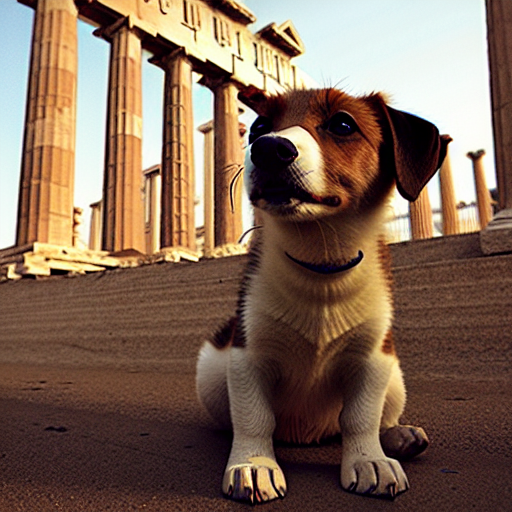

In [12]:
from PIL import Image

prompt = "A <my_dog> dog in the Acropolis"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


# SAMPLER

sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


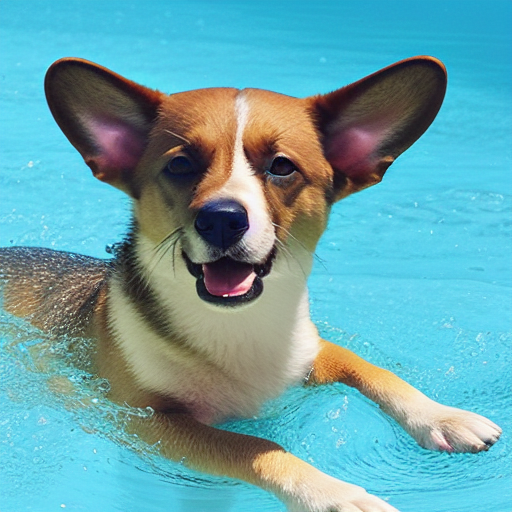

In [16]:
from PIL import Image

prompt = "A <my_dog> dog swimming"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


# SAMPLER

sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


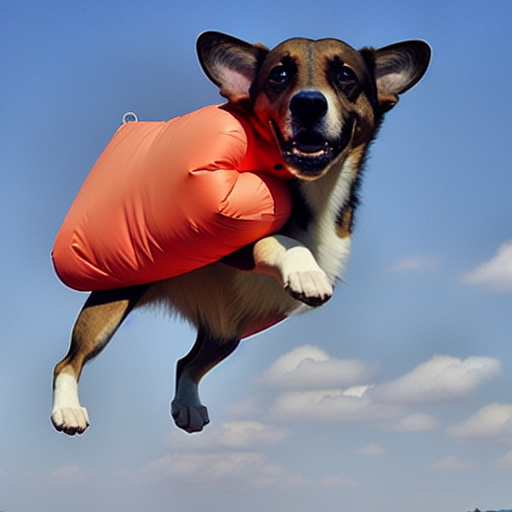

In [17]:
from PIL import Image

prompt = "<my_dog> dog parachuting"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


# SAMPLER

sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


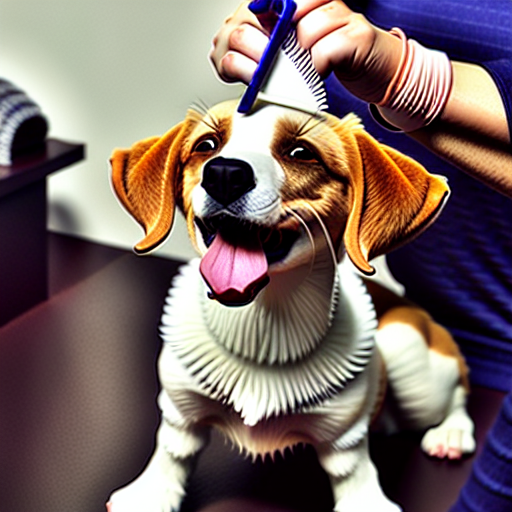

In [24]:
from PIL import Image

prompt = "<my_dog> dog getting a haircut"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


# SAMPLER

sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


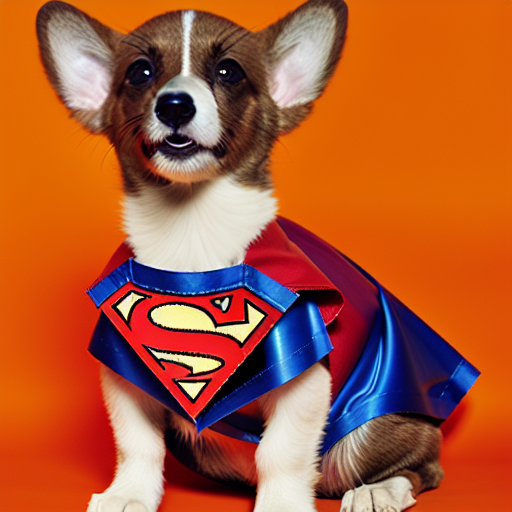

In [37]:
from PIL import Image

prompt = "<my_dog> dog wearing Superman Outfit"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 7 # min: 1, max: 14


# SAMPLER

sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)